# Introduction



This analysis aims to optimize staffing solutions for long-term care facilities across the United States by providing the sales leadership team with actionable insights derived from staffing and quality data. By ensuring that nursing homes have reliable access to both full-time employees and qualified contractors, staffing solutions can be enhanced, ultimately improving the quality of care for residents.

The data leveraged for this analysis includes the Payroll-Based Journal (PBJ) Daily Nurse Staffing dataset for the second quarter of 2024 from the Centers for Medicare and Medicaid Services (CMS). In addition to the PBJ dataset, the MDS Quality Measures dataset has been incorporated to provide a more comprehensive view and to enrich the analysis.

The goal of this analysis is to identify staffing gaps, optimize resource allocation, and support strategic decision-making for the sales team.




Key features of the PBJ dataset:

- facility information

    `PROVNUM` - unique Medicare provider number for each facility

    `PROVNAME`, `CITY`, `STATE`, `COUNTY_NAME` - facility’s name and location details

- reporting period

    `CY_Qtr` - calendar quarter

    `WorkDate` - day for reported hours

- resident census

    `MDScensus` - number of residents in the facility
- staffing hours across different nursing roles, categorized into total hours, employee hours, and contract hours



# Data Cleaning & Preparation

Before proceeding with the analysis, I need to clean and preprocess the dataset to ensure accuracy and consistency.


#### Loading the Dataset

I begin by loading the Payroll-Based Journal (PBJ) Daily Nurse Staffing dataset for Q2 2024.

In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np

# load the dataset
data = pd.read_csv('./data/PBJ_Daily_Nurse_Staffing_Q2_2024.csv',
                   encoding='ISO-8859-1', low_memory=False)
# display first three rows
data.head(3)

,PROVNUM,PROVNAME,CITY,STATE,COUNTY_NAME,COUNTY_FIPS,CY_Qtr,WorkDate,MDScensus,Hrs_RNDON,...,Hrs_LPN_ctr,Hrs_CNA,Hrs_CNA_emp,Hrs_CNA_ctr,Hrs_NAtrn,Hrs_NAtrn_emp,Hrs_NAtrn_ctr,Hrs_MedAide,Hrs_MedAide_emp,Hrs_MedAide_ctr
0,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2024Q2,20240401,51,10.77,...,0.0,160.08,160.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2024Q2,20240402,52,8.43,...,0.0,135.95,135.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2024Q2,20240403,53,11.13,...,0.0,150.31,150.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Handling data types

The initial load of the dataset raised a DtypeWarning, indicating that the `PROVNUM` column contains mixed types (both numeric and string values). To ensure consistency, I convert it to a string.

In [3]:
data['PROVNUM'] = data['PROVNUM'].astype(str)



Let's check out the data types of the other columns in our data frame:


In [4]:
data.dtypes

PROVNUM              object
PROVNAME             object
CITY                 object
STATE                object
COUNTY_NAME          object
COUNTY_FIPS           int64
CY_Qtr               object
WorkDate              int64
MDScensus             int64
Hrs_RNDON           float64
Hrs_RNDON_emp       float64
Hrs_RNDON_ctr       float64
Hrs_RNadmin         float64
Hrs_RNadmin_emp     float64
Hrs_RNadmin_ctr     float64
Hrs_RN              float64
Hrs_RN_emp          float64
Hrs_RN_ctr          float64
Hrs_LPNadmin        float64
Hrs_LPNadmin_emp    float64
Hrs_LPNadmin_ctr    float64
Hrs_LPN             float64
Hrs_LPN_emp         float64
Hrs_LPN_ctr         float64
Hrs_CNA             float64
Hrs_CNA_emp         float64
Hrs_CNA_ctr         float64
Hrs_NAtrn           float64
Hrs_NAtrn_emp       float64
Hrs_NAtrn_ctr       float64
Hrs_MedAide         float64
Hrs_MedAide_emp     float64
Hrs_MedAide_ctr     float64
dtype: object

Additionally, the `WorkDate` column represents dates and should be converted to a proper datetime format.

In [5]:
# convert 'WorkDate' to datetime format
data['WorkDate'] = pd.to_datetime(data['WorkDate'].astype(str), format='%Y%m%d')

#### Removing Unnecesary Whitespaces

Columns containing string values may have leading or trailing whitespaces, which could affect data consistency. I will strip whitespaces from relevant columns.

In [6]:
# strip whitespaces from string columns
string_columns = ['PROVNUM', 'PROVNAME', 'CITY', 'STATE', 'COUNTY_NAME', 'CY_Qtr']
data[string_columns] = data[string_columns].apply(lambda x: x.str.strip())

#### Checking for Missing Values

To ensure data completeness, I check for any missing values in the dataset.

In [7]:
missing_values = data.isnull().sum().sum()

if missing_values == 0:
    print("✅ There are no missing values in the dataset.")
else:
    print(f"⚠️ The dataset contains {missing_values} missing values.")

✅ There are no missing values in the dataset.


#### Checking for Duplicates

To ensure data integrity, I check for duplicate rows.

In [8]:
duplicates = data.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

Number of duplicate rows: 0


Since there are no duplicate rows, I can proceed.

#### Examining Unique Values in Selected Columns

Understanding the uniqueness of values across columns helps us identify inconsistencies. I loop through selected columns and print the number of unique values in each:

In [9]:
columns = {'PROVNUM', 'PROVNAME', 'CITY', 'STATE', 'COUNTY_NAME', 'COUNTY_FIPS', 'CY_Qtr',
           'WorkDate', 'MDScensus'}

for column in columns:
    print(f'{column}: {data[column].nunique()} unique values')

STATE: 52 unique values
COUNTY_NAME: 1672 unique values
WorkDate: 91 unique values
CITY: 5086 unique values
MDScensus: 631 unique values
PROVNAME: 14378 unique values
PROVNUM: 14564 unique values
COUNTY_FIPS: 287 unique values
CY_Qtr: 1 unique values


One key observation is that `PROVNUM` (provider number) and `PROVNAME` (provider name) should have the same number of unique values for consistency. However, if `PROVNUM` has more unique values than `PROVNAME`, it means that some provider names correspond to multiple provider numbers.

#### Handling Multiple Provider Numbers for the Same Name

To maintain consistency, I will keep only the first occurrence of a provider number for names associated with multiple provider numbers.

In [10]:
# identify provider names linked to multiple provider numbers
provnum_counts = data.groupby('PROVNAME')['PROVNUM'].nunique()
provname_duplicates = provnum_counts[provnum_counts > 1].index.tolist()

# keep only the first occurrence of 'PROVNUM' for each 'PROVNAME' with duplicates
data = data[(data['PROVNAME'].isin(provname_duplicates) & ~data.duplicated(subset='PROVNAME', keep='first')) | 
                    (~data['PROVNAME'].isin(provname_duplicates))]

# print the updated number of unique values
print(f"Updated number of unique values in PROVNUM: {data['PROVNUM'].nunique()}")
print(f"Updated number of unique values in PROVNAME: {data['PROVNAME'].nunique()}")

Updated number of unique values in PROVNUM: 14378
Updated number of unique values in PROVNAME: 14378


#### Verifying the Time Period of the Data



Since I am analyzing data for Q2 2024, I check:

- `CY_Qtr` has only one unique value (Q2).
- `WorkDate` contains 91 unique values, corresponding to April (30 days) + May (31 days) + June (30 days).
- All dates fall within April–June 2024.



In [11]:
# verify unique values in 'CY_Qtr'
print(f"Unique values in CY_Qtr: {data['CY_Qtr'].unique()}")  

# verify number of unique dates in 'WorkDate'
print(f"Number of unique dates in WorkDate: {data['WorkDate'].nunique()}")  

# ensure all dates fall within Q2 2024
valid_years = data['WorkDate'].dt.year == 2024
valid_months = data['WorkDate'].dt.month.isin([4, 5, 6])

if valid_years.all() and valid_months.all():
    print("✅ WorkDate values are within the correct year (2024) and months (April–June).")
else:
    print("⚠️ Some WorkDate values fall outside the expected range.")

Unique values in CY_Qtr: ['2024Q2']
Number of unique dates in WorkDate: 91
✅ WorkDate values are within the correct year (2024) and months (April–June).


#### Standardizing Text Formatting



To ensure uniformity in text fields:

- Convert provider names and location data to uppercase.
- Format county names in title case for readability.



In [12]:
data.loc[:, 'PROVNAME'] = data['PROVNAME'].str.upper()
data.loc[:, 'CITY'] = data['CITY'].str.upper()
data.loc[:, 'STATE'] = data['STATE'].str.upper()
data.loc[:, 'COUNTY_NAME'] = data['COUNTY_NAME'].str.title()

#### Validating Total Hours Calculation

Before proceeding with the analysis, I must verify that total hours for each nursing role are correctly calculated as the sum of employee hours and contractor hours.

In [13]:
# define column groupings for employee, contractor, and total hours
columns = [('Hrs_RNDON_emp', 'Hrs_RNDON_ctr', 'Hrs_RNDON'),
           ('Hrs_RNadmin_emp', 'Hrs_RNadmin_ctr', 'Hrs_RNadmin'),
           ('Hrs_RN_emp', 'Hrs_RN_ctr', 'Hrs_RN'),
           ('Hrs_LPNadmin_emp', 'Hrs_LPNadmin_ctr', 'Hrs_LPNadmin'),
           ('Hrs_LPN_emp', 'Hrs_LPN_ctr', 'Hrs_LPN'),
           ('Hrs_CNA_emp', 'Hrs_CNA_ctr', 'Hrs_CNA'),
           ('Hrs_NAtrn_emp', 'Hrs_NAtrn_ctr', 'Hrs_NAtrn'),
           ('Hrs_MedAide_emp', 'Hrs_MedAide_ctr', 'Hrs_MedAide')]

# validate that total hours = employee hours + contractor hours for all roles
valid_hrs = all(
    (round(data[emp] + data[ctr], 2) == round(data[tot], 2)).all() for emp, ctr, tot in columns
)
if valid_hrs:
    print('✅ Employee hours and contract hours correctly sum up to total hours for all roles.')
else:
    print("⚠️ Discrepancies found in total hours calculations.")

✅ Employee hours and contract hours correctly sum up to total hours for all roles.


#### Sorting Data

To maintain chronological order, I sort the dataset by `WorkDate` in ascending order.

In [14]:
data = data.sort_values(by='WorkDate', ascending=True)

In [15]:
print("The dataset is now clean, validated, and ready for analysis! 🚀")

The dataset is now clean, validated, and ready for analysis! 🚀


# Anaysis

#### Grouping Data by Provider Name



I first aggregate the data by `PROVNAME`, calculating:

- Average number of residents per facility (`MDScensus_avg`)
- Total hours worked in different nursing roles (including totals and employees)



In [16]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [18]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')


# group data by provider name and calculate aggregates
data_group_PROVNAME = data.groupby('PROVNAME').agg(
    MDScensus_avg=('MDScensus', 'mean'),
    RNDON=('Hrs_RNDON', 'sum'),
    RNDON_emp=('Hrs_RNDON_emp', 'sum'),
    RNadmin=('Hrs_RNadmin', 'sum'),
    RNadmin_emp=('Hrs_RNadmin_emp', 'sum'),
    RN=('Hrs_RN', 'sum'),
    RN_emp=('Hrs_RN_emp', 'sum'),
    LPNadmin=('Hrs_LPNadmin', 'sum'),
    LPNadmin_emp=('Hrs_LPNadmin_emp', 'sum'),
    LPN=('Hrs_LPN', 'sum'),
    LPN_emp=('Hrs_LPN_emp', 'sum'),
    CNA=('Hrs_CNA', 'sum'),
    CNA_emp=('Hrs_CNA_emp', 'sum'),
    NAtrn=('Hrs_NAtrn', 'sum'),
    NAtrn_emp=('Hrs_NAtrn_emp', 'sum'),
    MedAide=('Hrs_MedAide', 'sum'),
    MedAide_emp=('Hrs_MedAide_emp', 'sum')
)

#### Consolidating Nursing Roles



To simplify the dataset, I consolidate related nursing roles into broader categories:

- Registered Nurses (RN) include RN Director of Nursing (`RNDON`), RN with administrative duties (`RNadmin`), and regular RN (`RN`).
- Licensed Practical Nurses (LPN) include LPN with administrative duties (`LPNadmin`) and regular LPN (`LPN`).



In [19]:
# combine all RN-related roles
data_group_PROVNAME['RN'] = (data_group_PROVNAME['RNDON'] + 
                             data_group_PROVNAME['RNadmin'] +
                             data_group_PROVNAME['RN'])
data_group_PROVNAME['RN_emp'] = (data_group_PROVNAME['RNDON_emp'] +
                                     data_group_PROVNAME['RNadmin_emp'] +
                                     data_group_PROVNAME['RN_emp'])
# drop old columns
data_group_PROVNAME.drop(columns=['RNDON', 'RNadmin', 'RNDON_emp', 'RNadmin_emp'], axis=1, inplace=True)

# combine all LPN-related roles
data_group_PROVNAME['LPN'] = (data_group_PROVNAME['LPNadmin'] + data_group_PROVNAME['LPN'])
data_group_PROVNAME['LPN_emp'] = (data_group_PROVNAME['LPNadmin_emp'] + data_group_PROVNAME['LPN_emp'])

# drop old columns
data_group_PROVNAME.drop(columns=['LPNadmin', 'LPNadmin_emp'], axis=1, inplace=True)

#### Sorting Aggregated Data

I sort the dataset by the average number of residents (`MDScensus_avg`) in descending order to prioritize larger facilities.

In [20]:
data_group_PROVNAME = data_group_PROVNAME.sort_values(by='MDScensus_avg', ascending=False)
# view the top facilities
data_group_PROVNAME.head(3)

,MDScensus_avg,RN,RN_emp,LPN,LPN_emp,CNA,CNA_emp,NAtrn,NAtrn_emp,MedAide,MedAide_emp
PROVNAME,,,,,,,,,,,
THE PLAZA REHAB AND NURSING CENTER,732.263736,40232.00,14011.00,34185.73,17108.00,117592.85,99929.25,0.0,0.0,0.0,0.0
ISABELLA GERIATRIC CENTER INC,683.175824,36933.04,21419.65,31979.97,14612.13,134845.14,93057.84,0.0,0.0,0.0,0.0
KINGS HARBOR MULTICARE CENTER,630.318681,27257.34,22523.56,37202.04,32559.96,125307.10,116550.43,0.0,0.0,0.0,0.0


#### Analyzing the Relationship Between Staffing and Residents

I explore the relationship between staffing levels and the number of residents. The total hours worked by nursing staff (RN, LPN, CNA, MedAide) is calculated as:
$$ TotalHoursWorked = RN + LPN + CNA + MedAide $$
I then visualize this relationship using a scatter plot to examine how staffing correlates with the average number of residents.

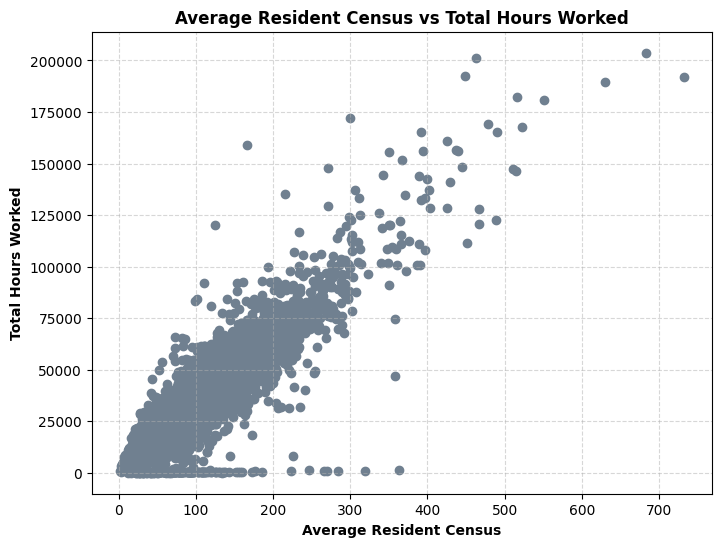

In [21]:
# calculate total hours worked excluding training hours
data_group_PROVNAME['TotHrs_work'] = (data_group_PROVNAME['RN'] + 
                                      data_group_PROVNAME['LPN'] +
                                      data_group_PROVNAME['CNA'] +
                                      data_group_PROVNAME['MedAide'])

# scatter plot
plt.figure(figsize=(8,6))
plt.scatter(data_group_PROVNAME['MDScensus_avg'], data_group_PROVNAME['TotHrs_work'], color='slategray')
plt.title('Average Resident Census vs Total Hours Worked', fontweight='bold')
plt.xlabel('Average Resident Census', fontweight='bold')
plt.ylabel('Total Hours Worked', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



Key insights 💡:

- There is a linear relationship between Average Resident Census and Total Hours Worked.
- Some facilities have low staffing levels despite a high resident count, appearing as a horizontal line at low Total Hours Worked values.



#### Identifying Understaffed Facilities

To identify facilities with insufficient staffing, I apply a log scale to the y-axis to zoom in and highlight some of the facilities that have low staffing relative to their resident count. These facilities are marked in red.

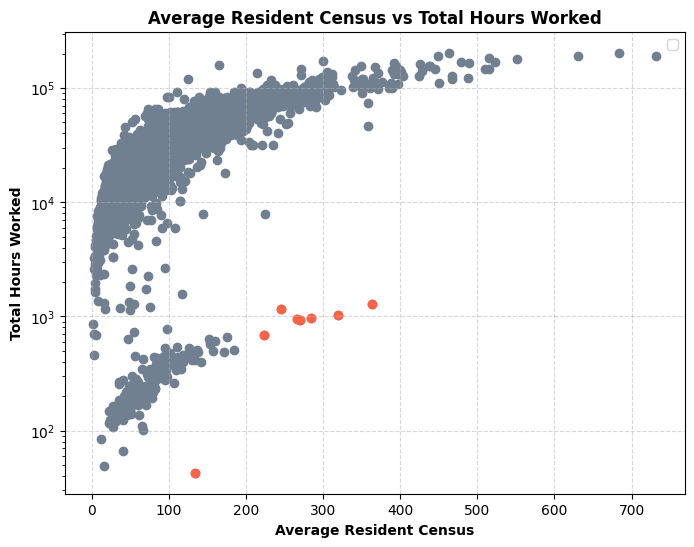

In [22]:
# apply log scale to the y-axis for better visibility
plt.figure(figsize=(8,6))
plt.scatter(data_group_PROVNAME['MDScensus_avg'], data_group_PROVNAME['TotHrs_work'], color='slategray')
plt.title('Average Resident Census vs Total Hours Worked', fontweight='bold')
plt.xlabel('Average Resident Census', fontweight='bold')
plt.ylabel('Total Hours Worked', fontweight='bold')
plt.yscale('log')

# identify facilities with very low staffing relative to their resident count
condition1 = (data_group_PROVNAME['TotHrs_work'] < 100) & (data_group_PROVNAME['MDScensus_avg'] > 100)
highlight1 = data_group_PROVNAME[condition1]
condition2 = (data_group_PROVNAME['TotHrs_work'] < 1300) & (data_group_PROVNAME['MDScensus_avg'] > 200)
highlight2 = data_group_PROVNAME[condition2]

# highlight these points in red
plt.scatter(highlight1['MDScensus_avg'], highlight1['TotHrs_work'], color='tomato')
plt.scatter(highlight2['MDScensus_avg'], highlight2['TotHrs_work'], color='tomato')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Key insight 💡:

- Red points indicate facilities that may be understaffed, as they have: high resident count (>100 or >200) but very low total hours worked (<100 or <1300).


To identify the exact facilities that require attention:

In [23]:
# list facilities with 'TotHrs_work' < 100 and 'MDScensus_avg' > 100
print('Facilities with less than 100 hours worked and more than 100 residents:\n')
condition = (data_group_PROVNAME['TotHrs_work'] < 100) & (data_group_PROVNAME['MDScensus_avg'] > 100)
data_group_PROVNAME[condition][['MDScensus_avg', 'TotHrs_work']]

Facilities with less than 100 hours worked and more than 100 residents:



,MDScensus_avg,TotHrs_work
PROVNAME,,
BEAR MOUNTAIN AT WORCESTER,134.175824,42.75


In [24]:
# list highlighted facilities with 'TotHrs_work' < 1300 and 'MDScensus_avg' > 200
print('Facilities with less than 1300 hours worked and more than 200 residents:\n')
condition = (data_group_PROVNAME['TotHrs_work'] < 1300) & (data_group_PROVNAME['MDScensus_avg'] > 200)
data_group_PROVNAME[condition][['MDScensus_avg', 'TotHrs_work']]

Facilities with less than 1300 hours worked and more than 200 residents:



,MDScensus_avg,TotHrs_work
PROVNAME,,
ST ANNS COMMUNITY,363.0,1280.94
HIGHLAND CARE CENTER,319.0,1030.57
CHRISTIAN HEALTH CARE CENTER,284.0,964.50
RIVERSIDE HEALTH & REHABILITATION,270.0,922.00
MEADOWBROOK CARE CENTER,266.0,953.99
WESTWOOD POST ACUTE,246.0,1167.03
MEADOWBROOK MANOR,223.0,691.25


#### Scatterplots of Staffing and Resident Census by Role

To gain further insights into staffing levels across different roles, I visualized the relationship between the average resident census and the hours worked by employees in specific nursing roles. Below are the scatterplots for each role:

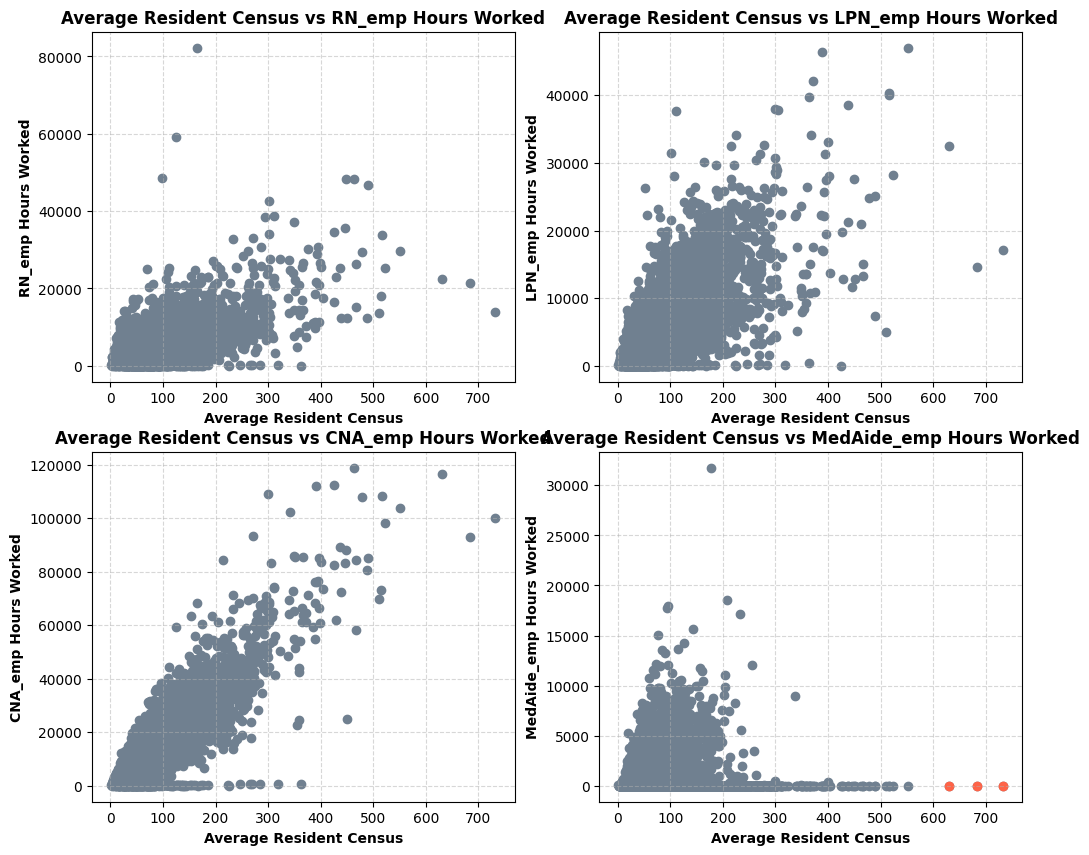

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

axs[0,0].scatter(data_group_PROVNAME['MDScensus_avg'], data_group_PROVNAME['RN_emp'], color='slategray')
axs[0,0].set_title('Average Resident Census vs RN_emp Hours Worked', fontweight='bold')
axs[0,0].set_xlabel('Average Resident Census', fontweight='bold')
axs[0,0].set_ylabel('RN_emp Hours Worked', fontweight='bold')
axs[0,0].grid(True, linestyle='--', alpha=0.5)

axs[0,1].scatter(data_group_PROVNAME['MDScensus_avg'], data_group_PROVNAME['LPN_emp'], color='slategray')
axs[0,1].set_title('Average Resident Census vs LPN_emp Hours Worked', fontweight='bold')
axs[0,1].set_xlabel('Average Resident Census', fontweight='bold')
axs[0,1].set_ylabel('LPN_emp Hours Worked', fontweight='bold')
axs[0,1].grid(True, linestyle='--', alpha=0.5)

axs[1,0].scatter(data_group_PROVNAME['MDScensus_avg'], data_group_PROVNAME['CNA_emp'], color='slategray')
axs[1,0].set_title('Average Resident Census vs CNA_emp Hours Worked', fontweight='bold')
axs[1,0].set_xlabel('Average Resident Census', fontweight='bold')
axs[1,0].set_ylabel('CNA_emp Hours Worked', fontweight='bold')
axs[1,0].grid(True, linestyle='--', alpha=0.5)

axs[1,1].scatter(data_group_PROVNAME['MDScensus_avg'], data_group_PROVNAME['MedAide_emp'], color='slategray')
axs[1,1].set_title('Average Resident Census vs MedAide_emp Hours Worked', fontweight='bold')
axs[1,1].set_xlabel('Average Resident Census', fontweight='bold')
axs[1,1].set_ylabel('MedAide_emp Hours Worked', fontweight='bold')
axs[1,1].grid(True, linestyle='--', alpha=0.5)

condition = (data_group_PROVNAME['MDScensus_avg'] > 600) & (data_group_PROVNAME['MedAide_emp'] < 100)
highlight = data_group_PROVNAME[condition]
axs[1,1].scatter(highlight['MDScensus_avg'], highlight['MedAide_emp'], color='tomato')

Key insight 💡:

- Inadequate MedAide staffing in facilities with high resident census.


The scatter plot for MedAide employee hours worked indicates a concerning pattern in facilities with a resident census exceeding 250. In these facilities, MedAide staff hours appear insufficient, with many facilities reporting less than 100 hours worked. This trend may suggest staffing deficiencies that could impact care quality. Below are examples of such facilities (highlighted as red dots):

In [26]:
print('Facilities highlithed as red dots with average resident census > 600'
       'and MedAide employee hours worked < 100:')
condition = (data_group_PROVNAME['MDScensus_avg'] > 600) & (data_group_PROVNAME['MedAide_emp'] < 100)
data_group_PROVNAME[condition][['MDScensus_avg', 'MedAide_emp']]

Facilities highlithed as red dots with average resident census > 600and MedAide employee hours worked < 100:


,MDScensus_avg,MedAide_emp
PROVNAME,,
THE PLAZA REHAB AND NURSING CENTER,732.263736,0.0
ISABELLA GERIATRIC CENTER INC,683.175824,0.0
KINGS HARBOR MULTICARE CENTER,630.318681,0.0


#### Distribution of Employee Hours by Role

The boxplot below shows the distribution of employee hours worked across different nursing roles (RN, LPN, CNA, and MedAide). From the plot, I observe that CNA employees generally work more hours than those in other roles across all facilities. [This is the reason why the plot of Average Resident Census vs CNA Employee Hours Worked resembles closely the plot of Average Resident Census vs Total Hours Worked.]

Text(0, 0.5, 'Hours Worked')

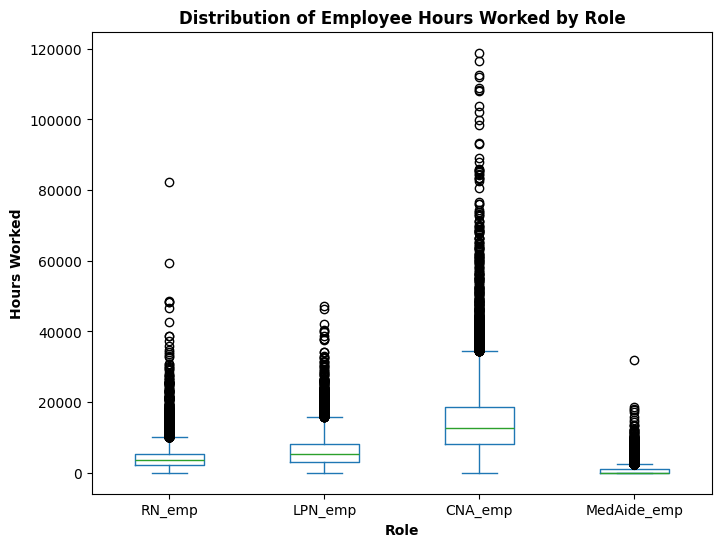

In [27]:
data_group_PROVNAME[['RN_emp', 'LPN_emp', 'CNA_emp', 'MedAide_emp']].plot(kind='box', figsize=(8, 6))
plt.title('Distribution of Employee Hours Worked by Role', fontweight='bold')
plt.xlabel('Role', fontweight='bold')
plt.ylabel('Hours Worked', fontweight='bold')

#### Resident Census Distribution

The distribution of the average number of residents across all facilities shows a peak around 50 residents per facility, with a positive skew indicating a smaller number of larger facilities.

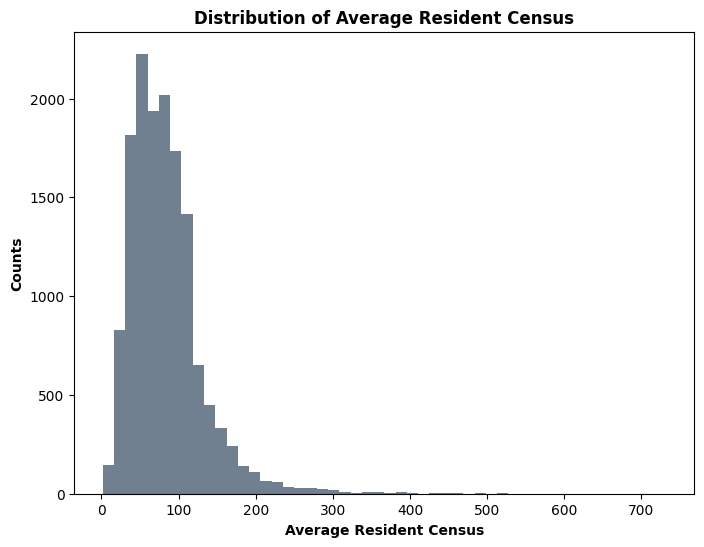

In [28]:
plt.figure(figsize=(8,6))
data_group_PROVNAME['MDScensus_avg'].hist(bins=50, color='slategrey')
plt.title('Distribution of Average Resident Census', fontweight='bold')
plt.xlabel('Average Resident Census', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')
plt.grid(False)
plt.show()



Key insight 💡:

- Most facilities are small to mid-sized, with fewer than 200 residents. This trend provides valuable context when evaluating staffing needs and optimizing resource allocation for larger facilities.



#### Analysis of Healthcare Facility Staffing Across States



To better understand the distribution of healthcare providers and residents across different states, I grouped the data by state and computed:

- The number of unique healthcare providers per state.
- The total number of residents in these facilities.



In [29]:
# group by state and count the number of unique facilities per state
data_group_STATE_PROVNAME = data.groupby('STATE', observed=False)['PROVNAME'].nunique().reset_index()

# group by state and sum the total number of residents per state
data_group_STATE_MDScensus = data.groupby('STATE', observed=False)['MDScensus'].sum().reset_index()

# merge the two grouped datasets on 'STATE' to combine facility count and total census per state
merged_data = pd.merge(data_group_STATE_PROVNAME, data_group_STATE_MDScensus, on='STATE')
merged_data.columns = ['STATE', 'num_PROVNAME', 'MDScensus_tot']

# display the first three rows of the merged dataset
merged_data.head(3)

,STATE,num_PROVNAME,MDScensus_tot
0,AK,14,57965
1,AL,222,1917877
2,AR,216,1445162


Since these two metrics are on different scales, I applied Min-Max Scaling to normalize them within the range [0,1] for effective comparison. The side-by-side bar plot below illustrates the relationship between the number of providers and residents in each state.

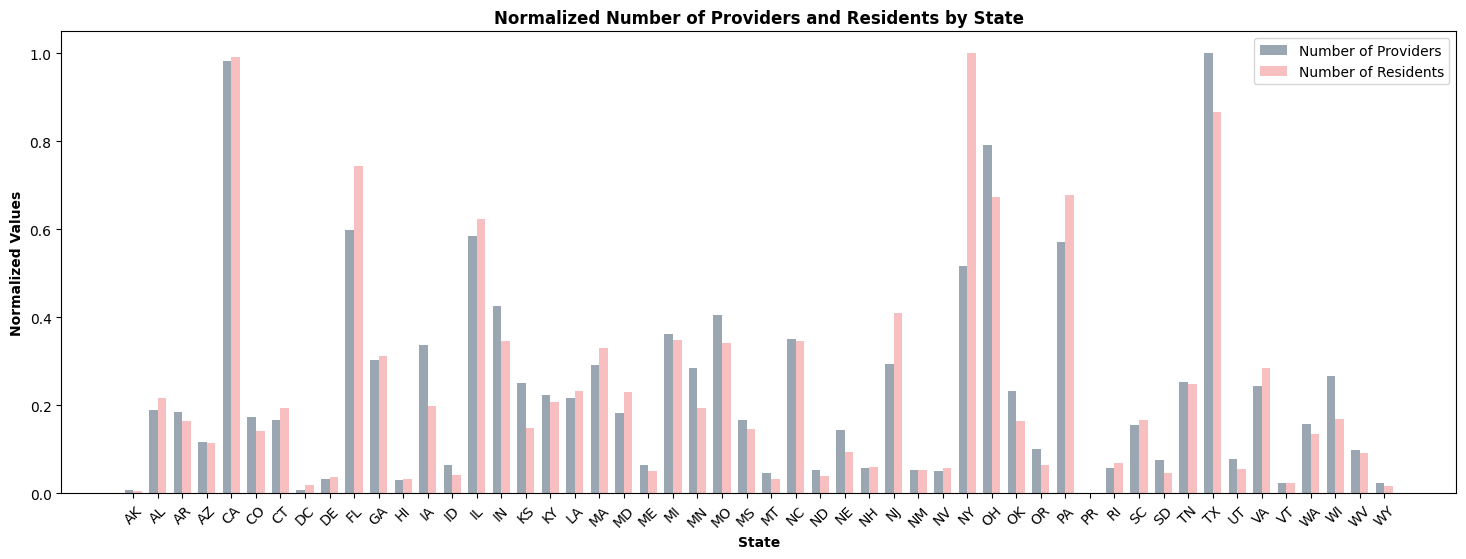

In [30]:
# initializing the MinMaxScaler
scaler = MinMaxScaler()
# applying MinMax scaling to 'num_PROVNAME' and 'MDScensus_tot' columns
merged_data['num_PROVNAME'] = scaler.fit_transform(merged_data[['num_PROVNAME']])
merged_data['MDScensus_tot'] = scaler.fit_transform(merged_data[['MDScensus_tot']])

# the label locations
x = np.arange(len(merged_data['STATE']))  
# width of the bars in the bar chart
width = 0.35  

plt.figure(figsize=(18, 6))
plt.bar(x - width/2, merged_data['num_PROVNAME'], width=width, label='Number of Providers', 
        alpha=0.7, color='slategrey')
plt.bar(x + width/2, merged_data['MDScensus_tot'], width=width, label='Number of Residents',
        alpha=0.5, color='lightcoral')
plt.xlabel('State', fontweight='bold')
plt.ylabel('Normalized Values', fontweight='bold')
plt.title('Normalized Number of Providers and Residents by State', fontweight='bold')
plt.xticks(x, merged_data['STATE'], rotation=45)
plt.legend()
plt.show()



Key insight 💡:

- New York (NY) stands out, as the normalized number of residents is nearly twice that of providers. This suggests that facilities in New York are either larger in capacity or overcrowded, potentially indicating higher patient-to-staff ratios and resource strain.



#### Contractor-to-Employee Ratio in Healthcare Facilities

To evaluate the reliance on contractors versus full-time employees, I analyzed total hours worked by both categories across different roles. The contractor-to-employee ratio was calculated as:
$$ Contractor-to-employee-ratio = \frac{TotalContractorHours}{TotalEmployeeHours} $$
A ratio greater than 1 indicates heavy reliance on contractors, which may be linked to higher operational costs and workforce instability.

In [31]:
# group by 'PROVNAME' and sum hours worked for different employee types and contract workers
emp_ctr_hrs = data.groupby('PROVNAME').agg({
    'Hrs_RNDON_emp': 'sum',
    'Hrs_RNDON_ctr': 'sum',
    'Hrs_RNadmin_emp': 'sum',
    'Hrs_RNadmin_ctr': 'sum',
    'Hrs_RN_emp': 'sum',
    'Hrs_RN_ctr': 'sum',
    'Hrs_LPNadmin_emp': 'sum',
    'Hrs_LPNadmin_ctr': 'sum',
    'Hrs_LPN_emp': 'sum',
    'Hrs_LPN_ctr': 'sum',
    'Hrs_CNA_emp': 'sum',
    'Hrs_CNA_ctr': 'sum',
    'Hrs_MedAide_emp': 'sum',
    'Hrs_MedAide_ctr': 'sum'
}).reset_index()

# calculate the total hours worked by all employed staff in each facility
emp_ctr_hrs['Tot_Hrs_emp'] = emp_ctr_hrs.filter(like='_emp').sum(axis=1)
# calculate the total hours worked by all contract staff in each facility
emp_ctr_hrs['Tot_Hrs_ctr'] = emp_ctr_hrs.filter(like='_ctr').sum(axis=1)

# calculate the contractor-to-employee ratio, avoiding division by zero
emp_ctr_hrs['ctr_to_emp_ratio'] = emp_ctr_hrs['Tot_Hrs_ctr'] / emp_ctr_hrs['Tot_Hrs_emp'].replace(0, np.nan)

# drop unnecessary columns
emp_ctr_hrs.drop(columns={'Hrs_RNDON_emp', 'Hrs_RNDON_ctr', 'Hrs_RNadmin_emp', 'Hrs_RNadmin_ctr',
                          'Hrs_RN_emp', 'Hrs_RN_ctr', 'Hrs_LPNadmin_emp', 'Hrs_LPNadmin_ctr',
                          'Hrs_LPN_emp', 'Hrs_LPN_ctr', 'Hrs_CNA_emp', 'Hrs_CNA_ctr',
                          'Hrs_MedAide_emp', 'Hrs_MedAide_ctr'}, axis=1, inplace=True)
# display the first 3 rows of the processed dataset
emp_ctr_hrs.head(3)

,PROVNAME,Tot_Hrs_emp,Tot_Hrs_ctr,ctr_to_emp_ratio
0,15 CRAIGSIDE,19514.34,0.00,0.000000
1,24TH PLACE,18568.35,0.00,0.000000
2,60 WEST,34179.80,947.72,0.027727


Text(0, 0.5, 'Counts')

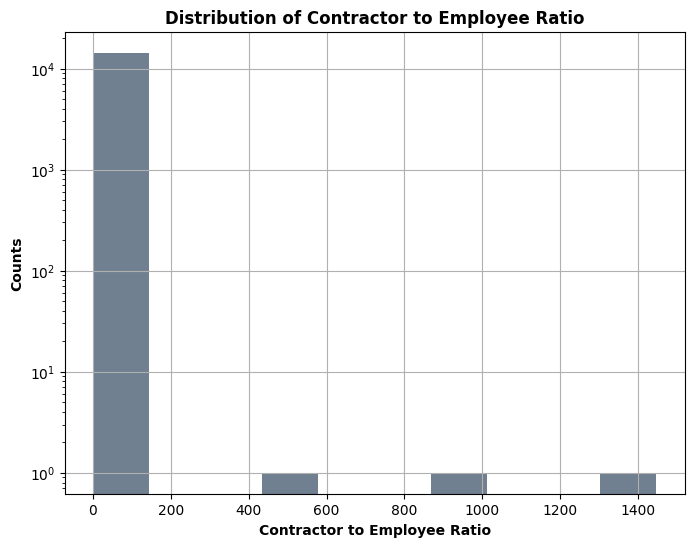

In [32]:
plt.figure(figsize=(8,6))
emp_ctr_hrs['ctr_to_emp_ratio'].hist(bins=10, color='slategrey')
plt.yscale('log')
plt.title('Distribution of Contractor to Employee Ratio', fontweight='bold')
plt.xlabel('Contractor to Employee Ratio', fontweight='bold')
plt.ylabel('Counts', fontweight='bold')



Key Insight 💡:

- The distribution shows extreme cases where the contractor-to-employee ratio is significantly above 1, highlighting facilities that are highly dependent on contract workers.



To identify the specific facilities exhibiting this trend, I can list those with a contractor-to-employee ratio above 200:

In [33]:
emp_ctr_hrs[emp_ctr_hrs['ctr_to_emp_ratio'] > 200]['PROVNAME']

1657             BLACKFEET CARE CENTER
9855      PREFERRED CARE AT CUMBERLAND
13365    VILLA SCALABRINI SPECIAL CARE
Name: PROVNAME, dtype: object

#### Integrating MDS Quality Measures Dataset



The other dataset that we will be using is the MDS Quality Measures, which contains quality measure scores based on resident assessments from the Minimum Data Set (MDS) for nursing homes. Each row represents a specific quality measure for a nursing home, including scores for each quarter (Q1 to Q4) and the four-quarter average.


In [34]:
# load the dataset
data_mds = pd.read_csv('./data/NH_QualityMsr_MDS_Nov2024.csv', low_memory=False)
# display the first three rows
data_mds.head(3)

,CMS Certification Number (CCN),Provider Name,Provider Address,City/Town,State,ZIP Code,Measure Code,Measure Description,Resident type,Q1 Measure Score,...,Q3 Measure Score,Footnote for Q3 Measure Score,Q4 Measure Score,Footnote for Q4 Measure Score,Four Quarter Average Score,Footnote for Four Quarter Average Score,Used in Quality Measure Five Star Rating,Measure Period,Location,Processing Date
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,401,Percentage of long-stay residents whose need f...,Long Stay,4.347830,...,11.363636,NaN,6.976744,NaN,7.303372,NaN,Y,2022Q4-2023Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2024-11-01
1,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,404,Percentage of long-stay residents who lose too...,Long Stay,2.325581,...,5.000000,NaN,14.285714,NaN,5.389222,NaN,N,2023Q3-2024Q2,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2024-11-01
2,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,405,Percentage of low risk long-stay residents who...,Long Stay,NaN,...,NaN,9.0,NaN,9.0,56.451613,NaN,N,2022Q4-2023Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2024-11-01


#### Dataset Overview & Cleaning

Below I will clean the dataset and select the relevant parts that align with our analysis.



The dataset includes two measure periods:

- 2022Q4-2023Q3
- 2023Q3-2024Q2



In [35]:
# check the available measure periods  
data_mds['Measure Period'].unique()

array(['2022Q4-2023Q3', '2023Q3-2024Q2'], dtype=object)

Since I am analyzing 2024Q2, I will filter the dataset to retain only records from 2023Q3-2024Q2.

In [36]:
# filter for the latest available measure period  
data_mds = data_mds[data_mds['Measure Period'] == '2023Q3-2024Q2']

# drop the 'Measure Period' column as it is no longer needed  
data_mds.drop(columns='Measure Period', axis=1, inplace=True)

Since our PBJ staffing data is from 2024Q2, the `Q4 Measure Score` corresponds to the relevant quarter for our analysis. I will remove unnecessary columns to keep only the relevant data for our study.

In [37]:
data_mds.columns

Index(['CMS Certification Number (CCN)', 'Provider Name', 'Provider Address',
       'City/Town', 'State', 'ZIP Code', 'Measure Code', 'Measure Description',
       'Resident type', 'Q1 Measure Score', 'Footnote for Q1 Measure Score',
       'Q2 Measure Score', 'Footnote for Q2 Measure Score', 'Q3 Measure Score',
       'Footnote for Q3 Measure Score', 'Q4 Measure Score',
       'Footnote for Q4 Measure Score', 'Four Quarter Average Score',
       'Footnote for Four Quarter Average Score',
       'Used in Quality Measure Five Star Rating', 'Location',
       'Processing Date'],
      dtype='object')

In [38]:
# drop unused columns  
data_mds = data_mds.drop(columns={'CMS Certification Number (CCN)', 'Provider Address', 'City/Town', 
                                  'State', 'ZIP Code','Measure Code', 'Resident type', 'Q1 Measure Score', 
                                  'Footnote for Q1 Measure Score', 'Q2 Measure Score',
                                  'Footnote for Q2 Measure Score', 'Q3 Measure Score', 
                                  'Footnote for Q3 Measure Score', 'Footnote for Q4 Measure Score',
                                  'Four Quarter Average Score', 'Footnote for Four Quarter Average Score',
                                  'Used in Quality Measure Five Star Rating', 'Location', 'Processing Date',
                                     })

To ensure data integrity, I will remove duplicate rows and drop missing values in the `Q4 Measure Score`, as this metric is essential for our analysis.

In [39]:
# remove duplicate rows  
data_mds = data_mds.drop_duplicates()

# drop rows where 'Q4 Measure Score' is missing  
data_mds = data_mds.dropna(subset=['Q4 Measure Score'])

The dataset includes multiple quality measures. To maintain a focused analysis, I will examine "Percentage of long-stay residents experiencing one or more falls with major injury", as fall-related injuries significantly impact resident well-being and facility performance.

In [40]:
# check available measure descriptions  
data_mds['Measure Description'].unique()

array(['Percentage of long-stay residents who lose too much weight',
       'Percentage of long-stay residents with a catheter inserted and left in their bladder',
       'Percentage of long-stay residents with a urinary tract infection',
       'Percentage of long-stay residents who have depressive symptoms',
       'Percentage of long-stay residents who were physically restrained',
       'Percentage of long-stay residents experiencing one or more falls with major injury',
       'Percentage of long-stay residents assessed and appropriately given the pneumococcal vaccine',
       'Percentage of long-stay residents who received an antipsychotic medication',
       'Percentage of short-stay residents assessed and appropriately given the pneumococcal vaccine',
       'Percentage of short-stay residents who newly received an antipsychotic medication',
       'Percentage of long-stay residents who received an antianxiety or hypnotic medication',
       'Percentage of long-stay residents a

I will filter the dataset to include only this quality measure and drop the corresponding column since it will no longer be needed.

In [41]:
# keep only the quality measure related to falls with major injury  
data_mds = data_mds[
data_mds['Measure Description'] == 'Percentage of long-stay residents experiencing one or more falls with major injury'
]

# drop the 'Measure Description' column as it is no longer necessary  
data_mds.drop(columns={'Measure Description'}, inplace=True)

#### Grouping and Aggregating the PBJ Dataset

In this step, I will group the PBJ dataset by provider name and calculate the average number of residents, the total employee hours worked for each role, and the total hours spent on nurse aide training.

In [42]:
# group the data by provider name and aggregate relevant data for each facility
data_pbj = data.groupby('PROVNAME').agg(
    MDScensus_avg=('MDScensus', 'mean'),
    RNDON_emp=('Hrs_RNDON_emp', 'sum'),
    RNadmin_emp=('Hrs_RNadmin_emp', 'sum'),
    RN_emp=('Hrs_RN_emp', 'sum'),
    LPNadmin_emp=('Hrs_LPNadmin_emp', 'sum'),
    LPN_emp=('Hrs_LPN_emp', 'sum'),
    CNA_emp=('Hrs_CNA_emp', 'sum'),
    NAtrn_emp=('Hrs_NAtrn_emp', 'sum'),
    MedAide_emp=('Hrs_MedAide_emp', 'sum')
)

# combine RN-related columns to calculate total RN hours
data_pbj['RN_emp_tot'] = (data_pbj['RNDON_emp'] + data_pbj['RNadmin_emp'] + data_pbj['RN_emp'])                                    
data_pbj.drop(columns=['RNDON_emp', 'RNadmin_emp', 'RN_emp'], axis=1, inplace=True)
data_pbj.rename(columns={'RN_emp_tot': 'RN_emp'}, inplace=True)

# combine LPN-related columns to calculate total LPN hours
data_pbj['LPN_emp_tot'] = (data_pbj['LPNadmin_emp'] + data_pbj['LPN_emp'])
data_pbj.drop(columns=['LPNadmin_emp', 'LPN_emp'], axis=1, inplace=True)
data_pbj.rename(columns={'LPN_emp_tot': 'LPN_emp'}, inplace=True)

# display the first few rows of the aggregated dataset
data_pbj.head(3)

,MDScensus_avg,CNA_emp,NAtrn_emp,MedAide_emp,RN_emp,LPN_emp
PROVNAME,,,,,,
15 CRAIGSIDE,43.274725,10976.67,171.21,0.0,7568.49,969.18
24TH PLACE,68.758242,10851.16,0.00,3364.8,1927.16,2425.23
60 WEST,92.582418,22246.30,0.00,0.0,4634.25,7299.25


#### Merging the PBJ and MDS Datasets



Next, I will merge the PBJ dataset with the MDS dataset based on the provider name (`PROVNAME`). This will allow me to analyze both staffing and quality metrics for each facility.


In [43]:
# rename column in MDS dataset for consistency
data_mds.rename(columns={'Provider Name': 'PROVNAME'}, inplace=True)

# merge the PBJ and MDS datasets on the 'PROVNAME' column
data_merged = pd.merge(data_pbj, data_mds, on='PROVNAME', how='inner')

# display the merged dataset
data_merged.head(3)

,PROVNAME,MDScensus_avg,CNA_emp,NAtrn_emp,MedAide_emp,RN_emp,LPN_emp,Q4 Measure Score
0,15 CRAIGSIDE,43.274725,10976.67,171.21,0.0,7568.49,969.18,4.651163
1,24TH PLACE,68.758242,10851.16,0.00,3364.8,1927.16,2425.23,1.587302
2,60 WEST,92.582418,22246.30,0.00,0.0,4634.25,7299.25,2.173913


#### Adding New Metrics to the Merged Dataset

I will now calculate additional key metrics for each facility:

`TotHrs_emp` - total employee hours

`TotHrs_per_resident` - total employee hours per resident

`NAtrn_per_resident` - nurse aide in training hours per residen

In [44]:
# calculate the total employee hours
data_merged['TotHrs_emp'] = (data_merged['RN_emp'] + data_merged['LPN_emp'] + 
                             data_merged['CNA_emp'] + data_merged['MedAide_emp'])

# calculate total employee hours per resident
data_merged['TotHrs_per_resident'] = data_merged['TotHrs_emp'] / data_merged['MDScensus_avg']

# calculate nurse aide training hours per resident
data_merged['NAtrn_per_resident'] = data_merged['NAtrn_emp'] / data_merged['MDScensus_avg']

#### Visualizing Total Employee Hours Worked vs Q4 Measure Score

Now, I will visualize the relationship between total employee hours worked per resident and the Q4 measure score (percentage of long-stay residents who experience falls with major injury). This scatter plot will help us assess any correlation.

Text(0, 0.5, 'Q4 Measure Score')

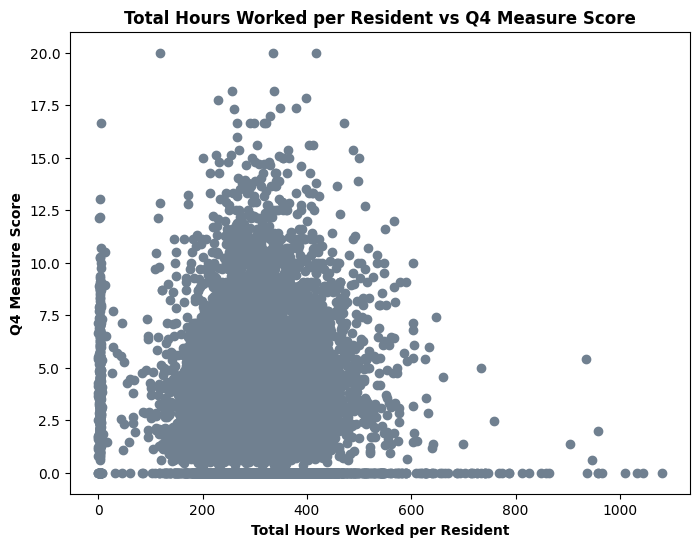

In [45]:
plt.figure(figsize=(8,6))
plt.scatter(data_merged['TotHrs_per_resident'], data_merged['Q4 Measure Score'], color='slategrey')
plt.title('Total Hours Worked per Resident vs Q4 Measure Score', fontweight='bold')
plt.xlabel('Total Hours Worked per Resident', fontweight='bold')
plt.ylabel('Q4 Measure Score', fontweight='bold')

Interpretation:

The scatter plot shows no clear linear relationship. The data points are concentrated between 150-500 total employee hours per resident, with Q4 measure scores between 0-10%.

Notably, there is a plateau at low injury rates, indicating that some facilities with varying staffing levels still report zero falls with major injuries. We should investigate these facilities, especially those with lower staffing hours, to identify best practices. Are they implementing better fall prevention protocols or utilizing advanced technologies?

#### Visualizing Nurse Aide Training Hours vs Q4 Measure Score

Next, I will visualize the nurse aide training hours per resident against the Q4 measure score. This plot will help determine if there’s any relationship between nurse aide training and fall injury rates.

Text(0.5, 0, 'Nurse Aide Training per Resident')

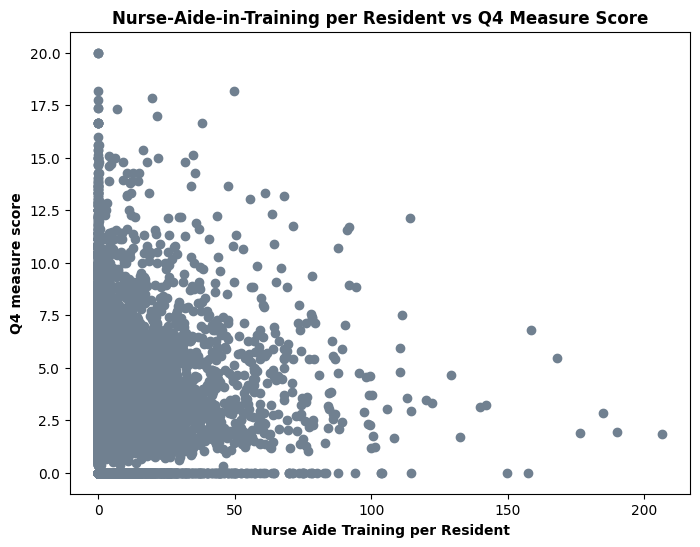

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(data_merged['NAtrn_per_resident'], data_merged['Q4 Measure Score'], color='slategrey')
plt.title('Nurse-Aide-in-Training per Resident vs Q4 Measure Score', fontweight='bold')
plt.ylabel('Q4 measure score', fontweight='bold')
plt.xlabel('Nurse Aide Training per Resident', fontweight='bold')

Key insight 💡:

- The plot shows a slight negative trend, suggesting that increasing nurse aide training hours may have a small, negative impact on injury rates. However, the weak correlation indicates that other factors, such as targeted fall prevention programs, likely contribute to the observed outcomes.


# Conclusion & Recommendations

This analysis provides key insights into staffing trends and challenges in long-term care facilities across the United States. By leveraging the Payroll-Based Journal (PBJ) Daily Nurse Staffing dataset and the MDS Quality Measures dataset, we have identified critical areas where staffing adjustments could enhance operational efficiency and improve resident care.

Key Findings:

- Staffing Gaps in High-Resident Facilities: A positive correlation exists between the average resident census and total hours worked, indicating that larger facilities generally have more staffing hours. However, certain facilities with high resident counts (>100 or >200) exhibit significantly low total hours worked (<100 or <1300), suggesting potential understaffing concerns.

- MedAide Staffing Shortages: Facilities with a resident census exceeding 250 often have insufficient MedAide staffing, with hours worked frequently falling below 100. Addressing this shortage is crucial to maintaining high-quality resident care.

- Heavy Reliance on Contract Workers: Some facilities have a contractor-to-employee ratio exceeding 1, indicating a dependence on temporary staffing solutions. While contract workers provide flexibility, excessive reliance may impact continuity of care and workforce stability. Increasing the proportion of permanent staff could enhance consistency and overall care quality.

- Regional Staffing Disparities: New York (NY) presents an anomaly, where the normalized number of residents per facility is nearly twice that of providers. This suggests either larger facility capacities or potential overcrowding, emphasizing the need for optimized staffing strategies in this region.

- Impact of Training on Resident Safety: A slight negative correlation was observed between nurse aide training hours and the percentage of residents experiencing falls with major injury. While the correlation is weak, this trend suggests that increased training initiatives could contribute to improved resident safety.





Recommendations:

1. Address Staffing Shortages in High-Risk Facilities

Prioritize staffing allocation in facilities, such as BEAR MOUNTAIN AT WORCESTER and ST ANNS COMMUNITY, with high resident counts but disproportionately low total hours worked.

2. Enhance MedAide Staffing in Large Facilities

Implement targeted recruitment and retention strategies for MedAide/Technician roles in high-demand facilities, such as THE PLAZA REHAB AND NURSING CENTER.

3. Reduce Dependence on Contract Workers

Develop long-term hiring strategies to increase permanent staff ratios in facilities with an overreliance on contractors, such as VILLA SCALABRINI SPECIAL CARE.

4. Mitigate Regional Disparities

Investigate staffing and resource allocation in New York to determine whether overcrowding or staffing inefficiencies are affecting resident care.

5. Strengthen Nurse Aide Training Programs

    Expand training programs for nurse aides, as preliminary findings suggest a potential link between training hours and reduced injury rates. Incorporate additional safety and fall prevention training into existing programs.

